In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchinfo import summary


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df = pd.read_csv('data/fer2013.csv')
print(df)

print(df['Usage'].unique())
print(df['Usage'].value_counts())

print(df['emotion'].value_counts())



       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]
['Training' 'PublicTest' '

   emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training   

  emotion_name  
0        angry  
1        angry  
2         fear  
3          sad  
4      neutral  


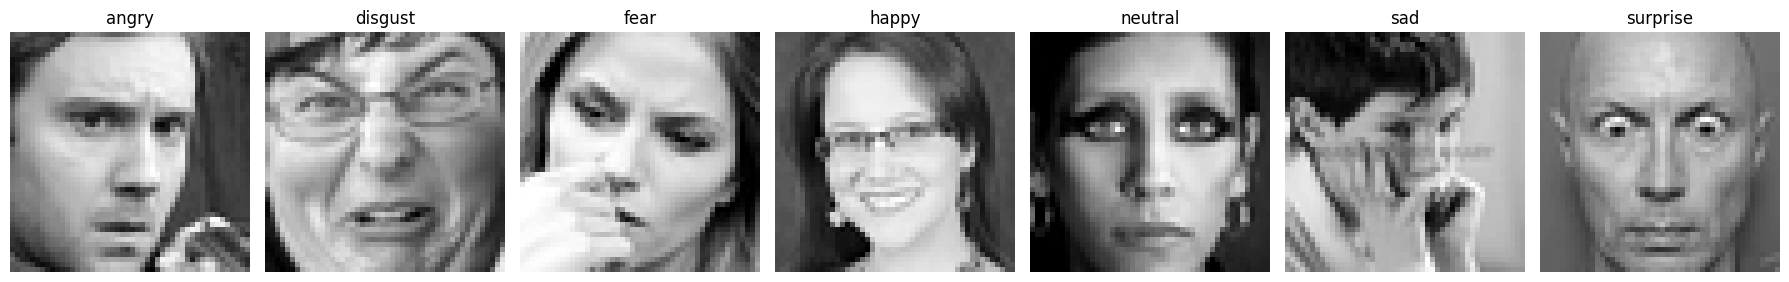

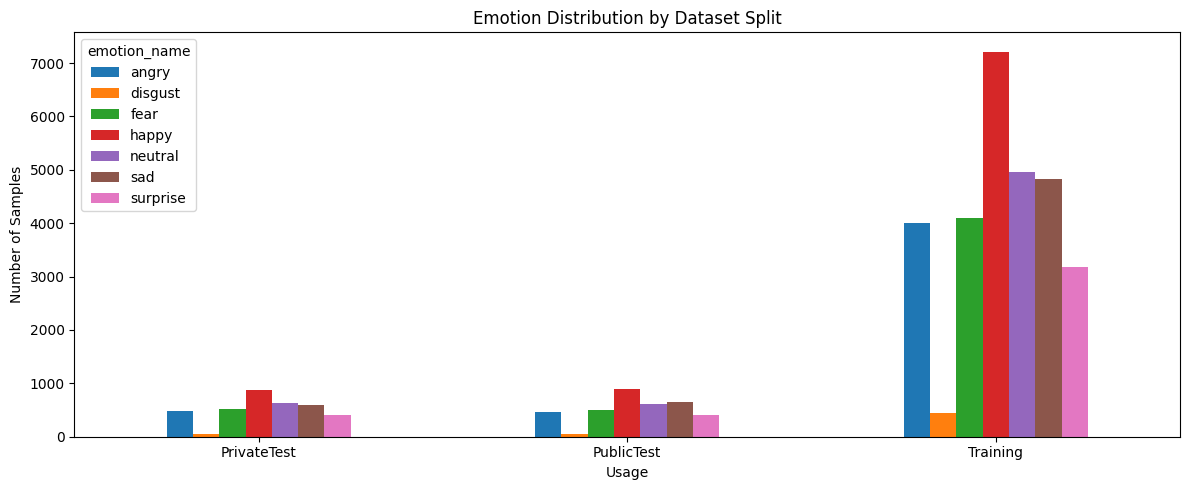

In [4]:
##Visualizing the data
 
# #Label mapping as per dataset info
emotion_map = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}
df['emotion_name'] = df['emotion'].map(emotion_map)
print(df.head())

#Plot grid of one image per emotion
fig, axes = plt.subplots(1, 7, figsize=(18,5))
for i, (label, group) in enumerate(df.groupby('emotion_name')):
    pixels = np.fromstring(group.iloc[0]['pixels'], sep = ' ', dtype='float32')
    image = pixels.reshape(48,48)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

df.groupby(['Usage', 'emotion_name']).size().unstack().plot(kind='bar', figsize=(12, 5))
plt.title("Emotion Distribution by Dataset Split")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
import torch
b = torch.randn(size=(2,2))
b.unsqueeze(dim=-1)
print(b.shape)

torch.Size([2, 2])


In [10]:
%%writefile src/dataset.py

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class FER2013Dataset(Dataset): #important to overwrite __len__ and __getitem__
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        pixels = np.fromstring(self.df.iloc[idx]['pixels'], sep=' ', dtype=np.float32)
        image = pixels.reshape(48,48) #FER resolution
        image = np.expand_dims(image, axis=0) #image_size = (1,48,48)

        if self.transform:
            image = self.transform(torch.tensor(image))

        label = int(self.df.iloc[idx]['emotion'])
        return image, label
    
def get_dataloaders(csv_path, batch_size=64):
    df = pd.read_csv(csv_path)
    
    #Relabeling to match inference labels
    #label_mapping = {0: 'angry', 1: 'disgust', 2: 'scared', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'}
    #df['emotion'] = df['emotion'].map({k: v for k, v in label_mapping.items()})

    # transform = transforms.Compose([
    #     transforms.Normalize(mean=[0.5], std=[0.5])
    # ])
    
    transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

    def df_by_usage(usage_type):
        return df[df['Usage'] == usage_type]
    
    train_set = FER2013Dataset(df_by_usage("Training"), transform=transform)
    val_set = FER2013Dataset(df_by_usage("PublicTest"), transform=transform)
    test_set = FER2013Dataset(df_by_usage("PrivateTest"), transform=transform)

    #create dataloaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader
    

Writing src/dataset.py


In [11]:
#testing above code

train_loader, val_loader, test_loader = get_dataloaders('data/fer2013.csv')

print(len(train_loader), len(val_loader), len(test_loader))

NameError: name 'get_dataloaders' is not defined

In [12]:
%%writefile src/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchinfo import summary

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        #conv block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, 
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2) #This will yield 24x24
        )

        #conv block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, 
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2) #This will yield 12x12
        )

        #conv block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, 
                      out_channels=96,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2) #This will yield 6x6
        )

        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(96*6*6, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

#print model summary using torchinfo.summary
model = EmotionCNN()
batch_size = 32
summary(model, input_size=(batch_size, 1, 48, 48))
    

Writing src/model.py


In [ ]:
%%writefile src/train.py

import torch
import torch.nn as nn
import torch.optim as optim
import os
# from src.dataset import get_dataloaders
# from src.model import EmotionCNN

def train_model(epochs=20, 
                batch_size=32, 
                lr=0.001, 
                model_save_path='checkpoints/emotion_cnn.pth'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    train_loader, val_loader, _ = get_dataloaders("data/fer2013.csv", batch_size=batch_size)

    model = EmotionCNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(),
                           lr = lr,
                           weight_decay=1e-4)
    
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            #fwd pass
            y_pred = model(images)
            
            #loss
            loss = loss_fn(y_pred, labels)
            total_loss += loss.item()

            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #get avg loss
        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)

        #validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.inference_mode():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                y_pred_val = model(images)
                _, predicted = torch.max(y_pred_val, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

            val_acc = val_correct / val_total

            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

            # Save best model
        if val_acc > best_val_acc:
            print("New best model found. Saving...")
            best_val_acc = val_acc
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)

if __name__ == "__main__":
    train_model()


Writing train.py


In [ ]:
%%writefile src/evaluate.py

import torch
import torch.nn as nn
# from src.dataset import get_dataloaders
# from src.model import EmotionCNN
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model_path = 'checkpoints/emotion_cnn.pth'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    #load test_loader
    _, _, test_loader = get_dataloaders("data/fer2013.csv")

    model = EmotionCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\nTest Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[
        "angry", "disgust", "scared", "happy", "sad", "surprised", "neutral"
    ]))

    #plot the confusion matrix

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=[
        "angry", "disgust", "scared", "happy", "sad", "surprised", "neutral"
    ], yticklabels=[
        "angry", "disgust", "scared", "happy", "sad", "surprised", "neutral"
    ], cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_model()

Writing evaluate.py


In [ ]:
%%writefile src/inference.py

import torch
import torch.nn.functional as F
import cv2
import numpy as np
# from src.model import EmotionCNN
from torchvision import transforms
import webbrowser

# Emotion classes (make sure they match your training)
emotion_labels = ["angry", "disgust", "scared", "happy", "sad", "surprised", "neutral"]

# Optional: Music URLs per emotion
music_links = {
    "angry": "https://music.youtube.com/search?q=calm+down",
    "disgust": "https://music.youtube.com/search?q=clean+vibes",
    "scared": "https://music.youtube.com/search?q=confidence+music",
    "happy": "https://music.youtube.com/search?q=happy+music",
    "sad": "https://music.youtube.com/search?q=cheer+up+music",
    "surprised": "https://music.youtube.com/search?q=energetic+music",
    "neutral": "https://music.youtube.com/search?q=background+lofi"
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = EmotionCNN().to(device)
model.load_state_dict(torch.load("checkpoints/emotion_cnn.pth", map_location=device))
model.eval()

# Preprocessing transform (must match training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

last_emotion = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi_gray, (48, 48))
        roi_normalized = transform(roi_resized).unsqueeze(0).to(device)  # shape: [1, 1, 48, 48]

        with torch.no_grad():
            output = model(roi_normalized)
            probs = F.softmax(output, dim=1)
            pred = torch.argmax(probs).item()
            label = emotion_labels[pred]

        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        if label != last_emotion:
            print(f"Detected emotion: {label}")
            webbrowser.open(music_links[label])
            last_emotion = label

    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Writing inference.py
